In [7]:
import pandas as pd
import geopandas as gpd
import maup
from maup import smart_repair
import time
import os
import matplotlib.pyplot as plt
import networkx as nx
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, Election
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import time
from gerrychain.tree import bipartition_tree

In [8]:
wi_file = gpd.read_file("./WI_DATA/WI.shp") # reads a file from ct directory
wi_graph = Graph.from_geodataframe(wi_file) # creates a graph from a geodataframe
print(wi_graph.nodes()[0]) # Prints out the attributes of each node in the graph
tot_pop = sum([wi_graph.nodes()[v]['TOTPOP'] for v in wi_graph.nodes()]) # gets the total population for ideal population calculation if the values are numbers
print(tot_pop)

KeyboardInterrupt: 

In [ ]:
elections = [Election("2020 Presidential", {"Democratic": "G20PRED", "Republican": "G20PRER"})]

In [ ]:
my_updaters = {
    "our cut edges": cut_edges, # number of cut edges in a graph
    "district population": Tally("TOTPOP", alias = "district population"), # across districts, total population 
    "democratic votes": Tally("G20PRED", alias = "democratic votes"), # across districts, number of democratic votes
    "republican votes": Tally("G20PRER", alias = "republican votes"), # across districts, number of republican votes
}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)
ct_partition = Partition( # creates a partition for the IL graph
    wi_graph, # dual graph
    assignment = "CD", # initial districting plan
    updaters=my_updaters)
print(ct_partition["district population"]) # Prints the population for each district
print(ct_partition["democratic votes"]) # prints the number of democratic votes for each district
print(ct_partition["republican votes"]) # prints the number of republican votes for each district
ideal_pop = tot_pop/8 # calculates the ideal population 
pop_tolerance = 0.05 # population tolerance for the proposal
print(ideal_pop)

{'3': 736959.0, '2': 736822.0, '6': 736545.0, '4': 736395.0, '1': 736286.0, '8': 736833.0, '7': 736572.0, '5': 737306.0}
{'3': 185134, '2': 310915, '6': 171907, '4': 260053, '1': 189936, '8': 170943, '7': 165821, '5': 176157}
{'3': 203656, '2': 125964, '6': 237024, '4': 78197, '1': 197794, '8': 234798, '7': 250139, '5': 282612}
736714.75


In [ ]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 100, ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                    #   allow_pair_reselection=True,
                        method = partial(
                        bipartition_tree,
                        max_attempts=100,
                        allow_pair_reselection=True  # <-- This is the only change
    )
                      )
population_constraint = constraints.within_percent_of_ideal_population(
    ct_partition, 
    pop_tolerance, 
    pop_key="district population")

In [10]:
# found this code in gerrychain_intro_complete-2.ipynb
start_time = time.time()
random_walk = MarkovChain( # random walk for 50000 steps
    proposal = rw_proposal, 
    constraints = [population_constraint], # Could add additional constraints here
    accept = always_accept, # Accept every proposed plan that meets the population constraints
    initial_state = ct_partition, 
    total_steps = 10000)

final_df = pd.DataFrame([])

for step, part in enumerate(random_walk):
    if(step != 0 and step % 500 == 0):
        print("At Step: ", step, "Time: ", (time.time() - start_time)/60)
    final_df.at[step, "Cut Edges"] = len(part["our cut edges"]) ## Cut edge ensemble
    final_df.at[step, "Democratic Districts"] = part["2020 Presidential"].seats("Democratic") ## Democratic Districts ensemble
    final_df.at[step, "Republican Districts"] = part["2020 Presidential"].seats("Republican") ## Republican Districts ensemble
    final_df.at[step, "Efficiency Gap"] = part["2020 Presidential"].efficiency_gap() ## Efficiency Gap ensemble

end_time = time.time()

print("The time of execution of above program is :",
      (end_time-start_time)/60, "mins")

final_df.to_csv('markov_chain_ensemble_results.csv', index=False)

At Step:  500 Time:  3.494972217082977
At Step:  1000 Time:  6.400694115956624
At Step:  1500 Time:  14.961679768562316
At Step:  2000 Time:  18.442224049568175
At Step:  2500 Time:  21.776914850870767
At Step:  3000 Time:  25.03443425099055
At Step:  3500 Time:  28.056384483973186
At Step:  4000 Time:  31.672968900203706
At Step:  4500 Time:  35.150061416625974
At Step:  5000 Time:  38.617221184571584
At Step:  5500 Time:  41.785707485675815
At Step:  6000 Time:  44.83206521670024
At Step:  6500 Time:  47.738905215263365
At Step:  7000 Time:  50.88767126401265
At Step:  7500 Time:  54.50783616701762
At Step:  8000 Time:  57.817925198872885
At Step:  8500 Time:  61.17828428347905
At Step:  9000 Time:  64.2724308848381
At Step:  9500 Time:  67.61486094792684
The time of execution of above program is : 71.27100433508555 mins


In [11]:
print(final_df["Cut Edges"])
print(final_df["Democratic Districts"])
print(final_df["Republican Districts"])
print(final_df["Efficiency Gap"])

0       672.0
1       681.0
2       697.0
3       703.0
4       706.0
        ...  
9995    729.0
9996    728.0
9997    724.0
9998    753.0
9999    745.0
Name: Cut Edges, Length: 10000, dtype: float64
0       2.0
1       2.0
2       2.0
3       2.0
4       2.0
       ... 
9995    2.0
9996    2.0
9997    2.0
9998    2.0
9999    2.0
Name: Democratic Districts, Length: 10000, dtype: float64
0       6.0
1       6.0
2       6.0
3       6.0
4       6.0
       ... 
9995    6.0
9996    6.0
9997    6.0
9998    6.0
9999    6.0
Name: Republican Districts, Length: 10000, dtype: float64
0      -0.267221
1      -0.260560
2      -0.265464
3      -0.270392
4      -0.268053
          ...   
9995   -0.266546
9996   -0.263245
9997   -0.262898
9998   -0.262898
9999   -0.262898
Name: Efficiency Gap, Length: 10000, dtype: float64


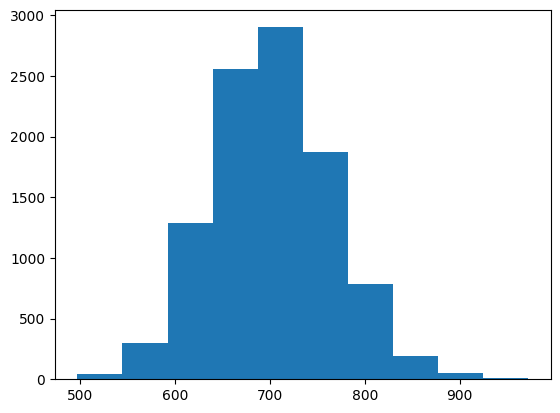

In [12]:
plt.figure()
plt.hist(final_df["Cut Edges"], align = 'left')
plt.show()